<a href="https://colab.research.google.com/github/cemlevent54/Neural_Network_Notes/blob/main/03_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

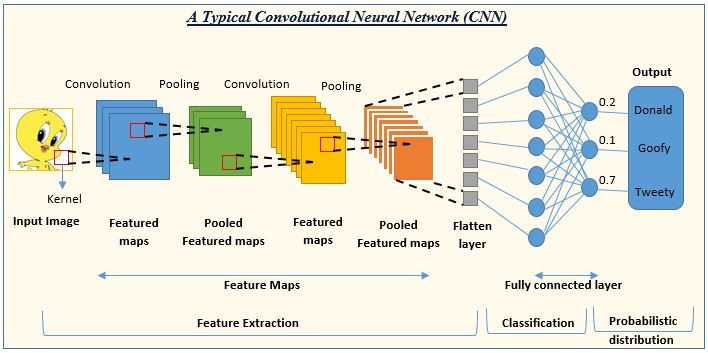

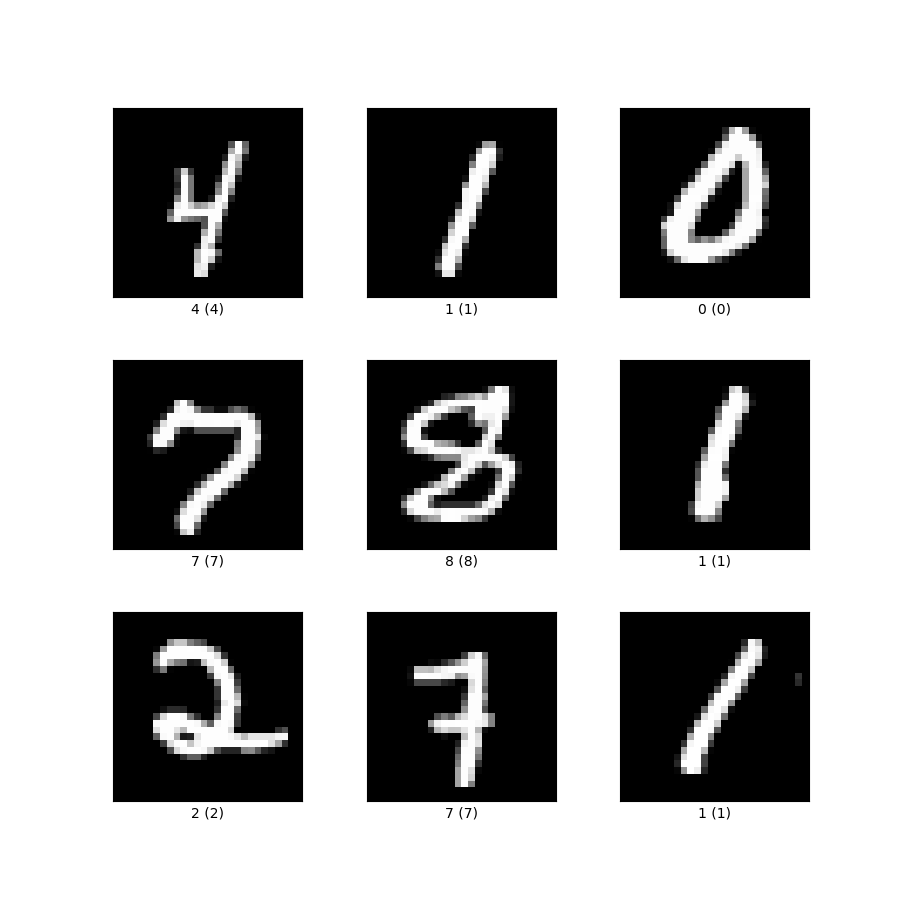

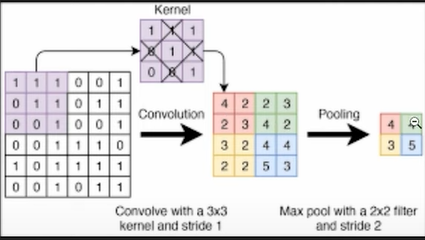

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
# Convert MNIST Image Files into a Tensor of 4-dimensions(# of images, height, width, color channel)
transform = transforms.ToTensor()


In [63]:
# training data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)


In [64]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [65]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [66]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [67]:
# create a small batch size for images ...
train_loader = DataLoader(train_data, batch_size= 10, shuffle=True) # mini_batch'de her seferde 10 kez veriliyor, shuffle=True için her epoch'ta veriler karışıyor
test_loader = DataLoader(test_data, batch_size= 10, shuffle=False)

In [68]:
# define our CNN Model
# describe convolutional layer and what it's doing (2 convolutional layer)

conv1 = nn.Conv2d(1,6,3,1) # input channel, filter, 3x3 kernel, 1 adım kaydırma
conv2 = nn.Conv2d(6,16,3,1)

In [69]:
# grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [70]:
X_train.shape

torch.Size([1, 28, 28])

In [71]:
x = X_train.view(1,1,28,28) #  (batch, kanal, yükseklik, genişlik)

**First Convolutional Layer**

In [72]:
x = F.relu(conv1(x)) # rectified linear unit for our activational function

In [73]:
x.shape # 1 single image, 6 is the filters, 26x26

torch.Size([1, 6, 26, 26])

In [74]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) # kernel of 2 and stride of 2

In [75]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

***Konvolüsyon özellikleri çıkarır, Pooling ise gerekli bilgiyi koruyarak hesaplama yükünü azaltır.***

**Second Convolutional Layer**

In [76]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [77]:
x.shape # again, we didn't set padding so we lose 2 pixles around the outsize of the image

torch.Size([1, 16, 11, 11])

In [78]:
x = F.max_pool2d(x, 2, 2) # pooling layer

In [79]:
x.shape # 11 / 2 = 5.5 but we have to round down, because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [80]:
(((28-2) / 2) - 2) / 2

5.5

**Model Class**

In [81]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-View to flatten it out ( CNN’den çıkan veriyi fully connected katmana vermek için vektöre çevirme.)
    X = X.view(-1, 16*5*5)

    # Fully Connected Layer
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)


In [82]:
# Create an Instance of our model
torch.manual_seed(41)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [83]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller the learning rate, longer its gonna take to train

**Training and Testing**

In [84]:
import time
start_time = time.time()
# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  # train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start bathces at 1
    # Apply the model
    y_pred = model(X_train) # get predicted values from the training set. Not flattened
    loss = criterion(y_pred, y_train) # how off are we? compare the predictions to correct answers in Y_train
    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch
    trn_corr += batch_corr # keep track as we go
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if b % 600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)
  # test
  with torch.no_grad():  # no gradient, so we don't update our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] #adding up correct predictions
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.16236107051372528
Epoch: 0 Batch: 1200 Loss: 0.15510495007038116
Epoch: 0 Batch: 1800 Loss: 0.4651116728782654
Epoch: 0 Batch: 2400 Loss: 0.17726822197437286
Epoch: 0 Batch: 3000 Loss: 0.007429888937622309
Epoch: 0 Batch: 3600 Loss: 0.37731707096099854
Epoch: 0 Batch: 4200 Loss: 0.004938055761158466
Epoch: 0 Batch: 4800 Loss: 0.0015040982980281115
Epoch: 0 Batch: 5400 Loss: 0.06845302879810333
Epoch: 0 Batch: 6000 Loss: 0.0004587689763866365
Epoch: 1 Batch: 600 Loss: 0.002925408538430929
Epoch: 1 Batch: 1200 Loss: 0.2792360186576843
Epoch: 1 Batch: 1800 Loss: 0.0018853390356525779
Epoch: 1 Batch: 2400 Loss: 0.0030733426101505756
Epoch: 1 Batch: 3000 Loss: 0.024190708994865417
Epoch: 1 Batch: 3600 Loss: 0.5062173008918762
Epoch: 1 Batch: 4200 Loss: 0.02014169655740261
Epoch: 1 Batch: 4800 Loss: 0.001421573688276112
Epoch: 1 Batch: 5400 Loss: 0.0006034405087120831
Epoch: 1 Batch: 6000 Loss: 0.1528162956237793
Epoch: 2 Batch: 600 Loss: 0.07298740744590759
Epoch

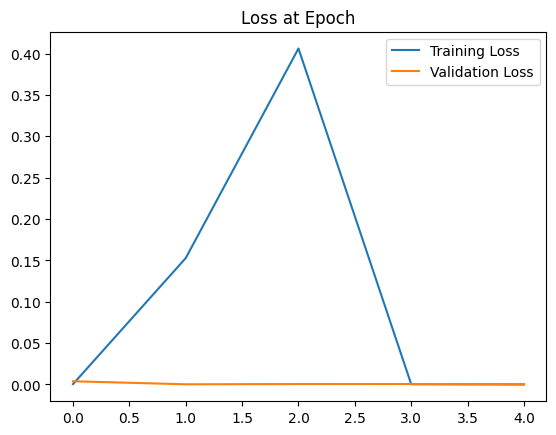

In [87]:
 # Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label= "Training Loss")
plt.plot(test_losses, label= "Validation Loss")
plt.title("Loss at Epoch")
plt.legend()


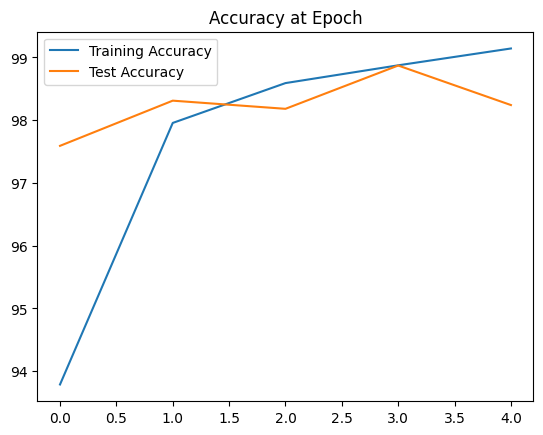

In [88]:
plt.plot([t / 600 for t in train_correct], label="Training Accuracy" )
plt.plot([t / 100 for t in test_correct], label="Test Accuracy")
plt.title("Accuracy at Epoch")
plt.legend()

In [89]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)


In [90]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

In [92]:
# Did for correct
correct.item()/len(test_data)*100

98.24000000000001

In [100]:
# grab an image
test_data[3020] # tensor with an image

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [101]:
test_data[3020][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [102]:
test_data[3020][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

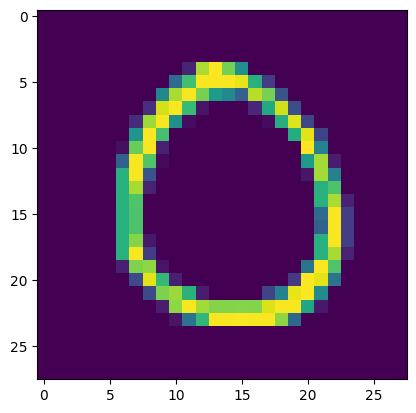

In [103]:
plt.imshow(test_data[3020][0].reshape(28,28))

In [104]:
model.eval()

with torch.no_grad():
  new_prediction = model(test_data[3020][0].view(1,1,28,28))

In [105]:
new_prediction

tensor([[-3.1709e-05, -2.7606e+01, -2.2111e+01, -2.4331e+01, -2.0215e+01,
         -2.0058e+01, -1.3730e+01, -2.4746e+01, -1.8388e+01, -1.0395e+01]])

In [106]:
new_prediction.argmax()

tensor(0)

In [109]:
len(test_data)

10000

In [110]:
# Modeli test moduna alıyoruz (gradyan hesaplamayı kapatıyoruz)
model.eval()

# Doğru tahmin edilen örnekleri sayacak değişken
correct = 0

# Tüm test verisini içeren bir DataLoader oluşturuyoruz
test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

# Gradyan hesaplamayı kapatarak test verisi üzerinde modelin tahmin yapmasını sağlıyoruz
with torch.no_grad():
    for X_test, y_test in test_loader:  # DataLoader ile test verisini iteratif olarak al
        y_val = model(X_test)  # Model tahmin yapıyor
        predicted = torch.max(y_val.data, 1)[1]  # En yüksek olasılığa sahip sınıfı al
        correct += (predicted == y_test).sum().item()  # Doğru tahminleri say

# Toplam doğruluk oranını hesapla
accuracy = correct / len(test_data) * 100
print(f"Test Set Accuracy: {accuracy:.2f}%")


Test Set Accuracy: 98.24%


In [111]:
model.eval()
correct = 0

with torch.no_grad():
    for i in range(len(test_data)):  # Test veri setindeki her görüntüyü al
        image, label = test_data[i]  # Görüntü ve doğru etiketi al
        image = image.view(1, 1, 28, 28)  # Modelin beklediği formata getir

        # Model tahmini yap
        output = model(image)
        predicted = output.argmax().item()  # En yüksek olasılıklı sınıfı seç

        # Doğru tahmin mi kontrol et
        if predicted == label:
            correct += 1

# Doğruluk hesapla
accuracy = correct / len(test_data) * 100
print(f"Test Set Accuracy (Tek Tek Hesaplama): {accuracy:.2f}%")


Test Set Accuracy (Tek Tek Hesaplama): 98.24%
